# Notebook 2: CNF com Trace Exato

Este notebook implementa CNF completo com cálculo de log-likelihood via change of variables.

## Objetivos:
1. Implementar divergence_exact e CNF
2. Treinar em dados 2D e MNIST reduzido
3. Comparar com Real NVP baseline
4. Analisar escalabilidade


In [1]:
import matplotlib.pyplot as plt
import sys
import os
sys.path.append('..')
import time
import torch
import torch.optim as optim
from src.models.cnf import CNF
from src.models.vector_field import VectorField2D
from src.utils.datasets import Synthetic2D, MNISTReduced, get_dataloader
from src.utils.training import train_cnf, train_realnvp
from src.utils.visualization import (
    Synthetic2DViz,
    MNISTViz,
)
from zuko.flows import RealNVP

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Directories for saving figures and checkpoints
FIGURES_DIR = '../results/figures'
CHECKPOINTS_DIR = '../results/checkpoints'
os.makedirs(FIGURES_DIR, exist_ok=True)
os.makedirs(CHECKPOINTS_DIR, exist_ok=True)


Using device: cuda


## 1. Dataset 2D

Figure saved to: ../results/figures/02_spirals_data.png


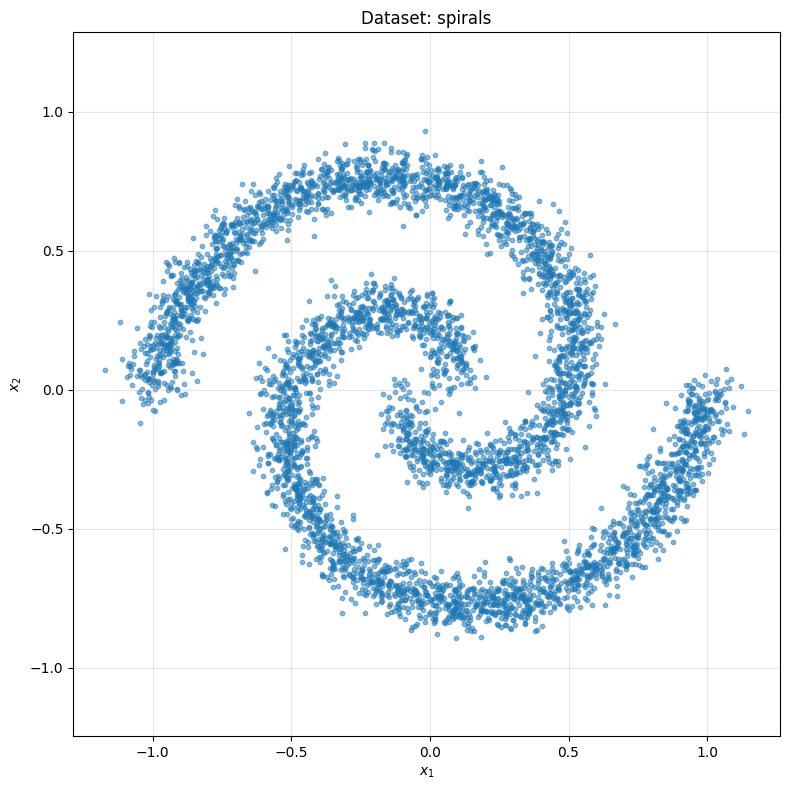

In [67]:
# Criar dataset 2D
DATASET_2D_NAME = 'spirals'
dataset_2d = Synthetic2D(n_samples=5000, noise=0.05, dataset_type=DATASET_2D_NAME)
dataloader_2d = get_dataloader(dataset_2d, batch_size=128, shuffle=True)

# Visualizar
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
Synthetic2DViz.plot_data_distribution(
    dataset_2d.data,
    ax=ax,
    title=f"Dataset: {DATASET_2D_NAME}",
    save_path=os.path.join(FIGURES_DIR, f'02_{DATASET_2D_NAME}_data.png')
)
plt.tight_layout()
plt.show()


### 1.1 CNF


In [68]:
# Criar e treinar CNF
vf_2d = VectorField2D(features=2, hidden_dims=[64, 64], time_embed_dim=16)
cnf_2d = CNF(vf_2d, trace_scale=0.75).to(device)
optimizer_2d = optim.Adam(cnf_2d.parameters(), lr=1e-3)

print("Treinando CNF em dados 2D...")
train_cnf(cnf_2d, dataloader_2d, optimizer_2d, n_epochs=50)

# Salvar checkpoint
checkpoint_path = os.path.join(
    CHECKPOINTS_DIR,
    f'02__{DATASET_2D_NAME}_cnf.pt'
)
torch.save(cnf_2d.state_dict(), checkpoint_path)
print(f"Checkpoint saved to: {checkpoint_path}")

# Avaliar log-likelihood
cnf_2d.eval()
with torch.no_grad():
    test_data = dataset_2d.data[:1000].to(device)
    log_probs = cnf_2d.log_prob(test_data)
    print(f"Log-likelihood médio: {log_probs.mean().item():.4f}")

Treinando CNF em dados 2D...


Epoch 1/50:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 1/50: 100%|██████████| 40/40 [00:19<00:00,  2.02it/s]


Epoch 1, Loss: 1.9110


Epoch 2/50:   2%|▎         | 1/40 [00:01<00:39,  1.02s/it]


KeyboardInterrupt: 

#### Visualization

Figure saved to: ../results/figures/02_spirals_cnf_transformation.png
Figure saved to: ../results/figures/02_spirals_cnf_vector_fields.png
Figure saved to: ../results/figures/02_spirals_cnf_vector_fields.png
Figure saved to: ../results/figures/02_spirals_cnf_vector_fields.png


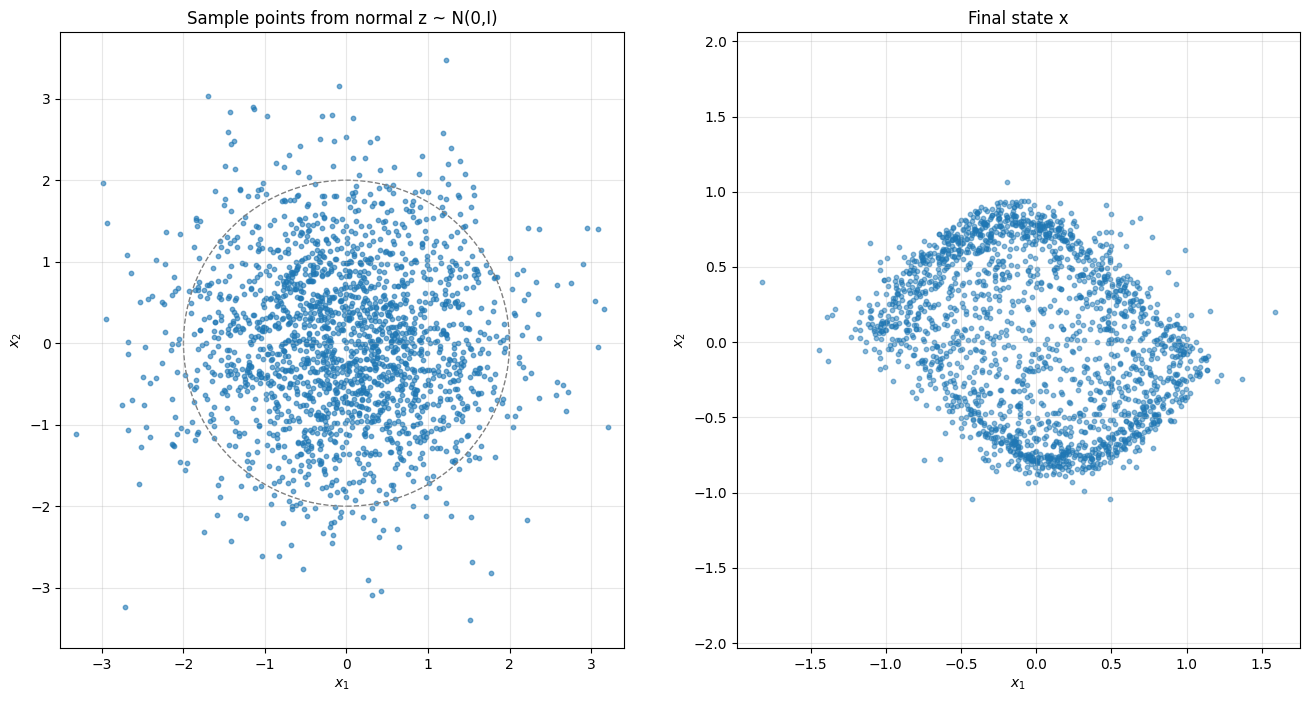

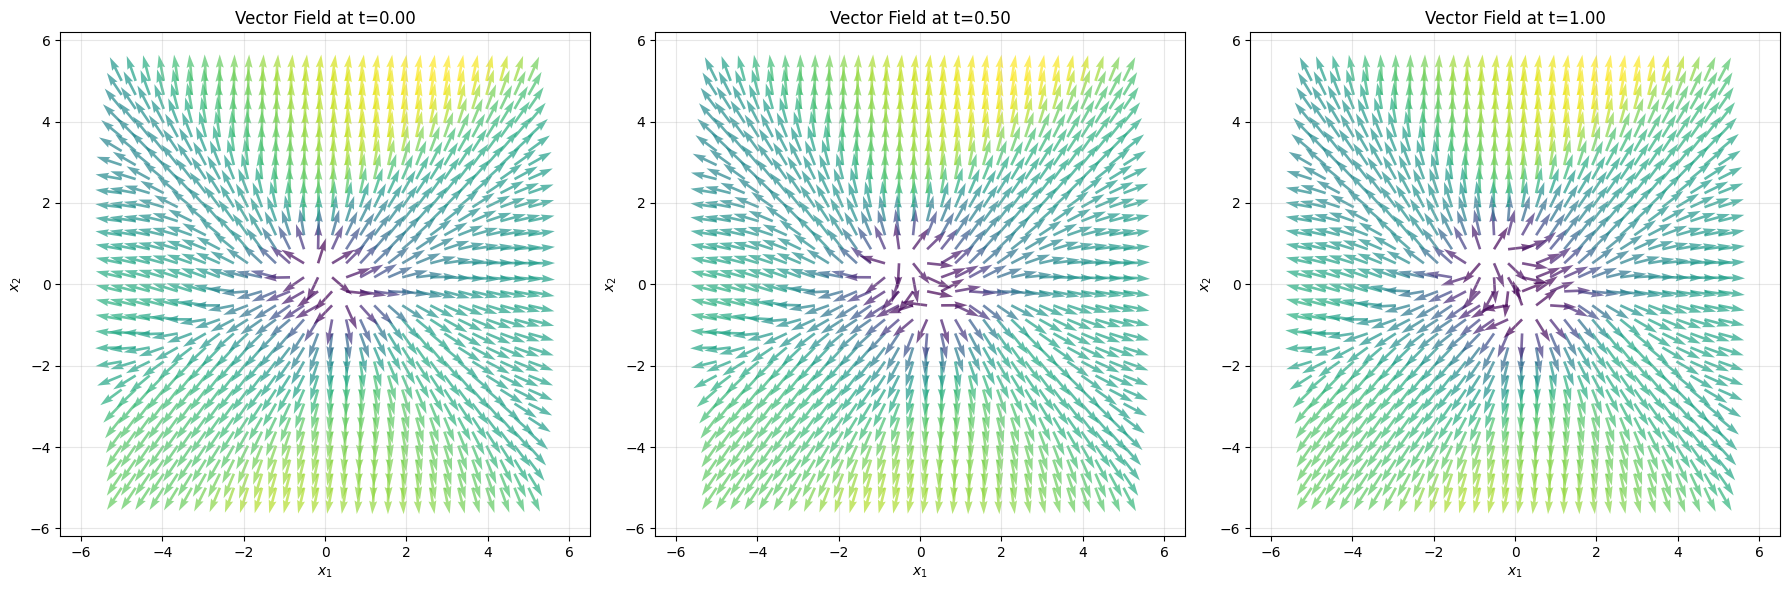

In [52]:
# Carregar modelo do checkpoint
checkpoint_path = os.path.join(
    CHECKPOINTS_DIR,
    f'02__{DATASET_2D_NAME}_cnf.pt'
)
vf_2d = VectorField2D(features=2, hidden_dims=[64, 64], time_embed_dim=16)
cnf_2d = CNF(vf_2d, trace_scale=0.75).to(device)
cnf_2d.load_state_dict(torch.load(checkpoint_path, map_location=device))
cnf_2d.eval()

Synthetic2DViz.plot_transformation(
    cnf_2d,
    n_steps=100,
    n_samples=2000,
    save_path=os.path.join(
        FIGURES_DIR,
        f'02_{DATASET_2D_NAME}_cnf_transformation.png'
    )
)
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
for i, t in enumerate([0.0, 0.5, 1.0]):
    Synthetic2DViz.plot_vector_field(
        cnf_2d,
        xlim=(-5, 5),
        ylim=(-5, 5),
        n_grid=30,
        t=t,
        ax=axes[i],
        save_path=os.path.join(
            FIGURES_DIR,
            f'02_{DATASET_2D_NAME}_cnf_vector_fields.png'
        )
    )
plt.tight_layout()
plt.show()

### 1.2. RealNVP


In [69]:
# Criar e treinar RealNVP em dados 2D
realnvp_2d = RealNVP(
    features=2,
    transforms=4,
    hidden_features=[64, 64]
).to(device)
optimizer_rnvp_2d = optim.Adam(realnvp_2d.parameters(), lr=5e-3)

print("Treinando RealNVP em dados 2D...")
train_realnvp(
    realnvp_2d,
    dataloader_2d,
    optimizer_rnvp_2d,
    device,
    n_epochs=50
)

# Salvar checkpoint
checkpoint_path = os.path.join(
    CHECKPOINTS_DIR,
    f'02__{DATASET_2D_NAME}_realnvp.pt'
)
torch.save(realnvp_2d.state_dict(), checkpoint_path)
print(f"Checkpoint saved to: {checkpoint_path}")

# Avaliar log-likelihood
realnvp_2d.eval()
with torch.no_grad():
    test_data = dataset_2d.data[:1000].to(device).to(torch.float32)
    dist = realnvp_2d(None)
    log_probs = dist.log_prob(test_data)
    print(f"Log-likelihood médio: {log_probs.mean().item():.4f}")

Treinando RealNVP em dados 2D...


Epoch 1/50: 100%|██████████| 40/40 [00:00<00:00, 91.12it/s] 


Epoch 1, Loss: 1.3384


Epoch 2/50: 100%|██████████| 40/40 [00:00<00:00, 138.74it/s]


Epoch 2, Loss: 1.1178


Epoch 3/50: 100%|██████████| 40/40 [00:00<00:00, 91.03it/s]


Epoch 3, Loss: 0.9603


Epoch 4/50: 100%|██████████| 40/40 [00:00<00:00, 89.98it/s] 


Epoch 4, Loss: 0.9620


Epoch 5/50:  12%|█▎        | 5/40 [00:00<00:00, 42.17it/s]


KeyboardInterrupt: 

#### Visualization

Figure saved to: ../results/figures/02_spirals_realnvp_transformation.png
Figure saved to: ../results/figures/02_spirals_realnvp_vector_fields.png
Figure saved to: ../results/figures/02_spirals_realnvp_vector_fields.png
Figure saved to: ../results/figures/02_spirals_realnvp_vector_fields.png


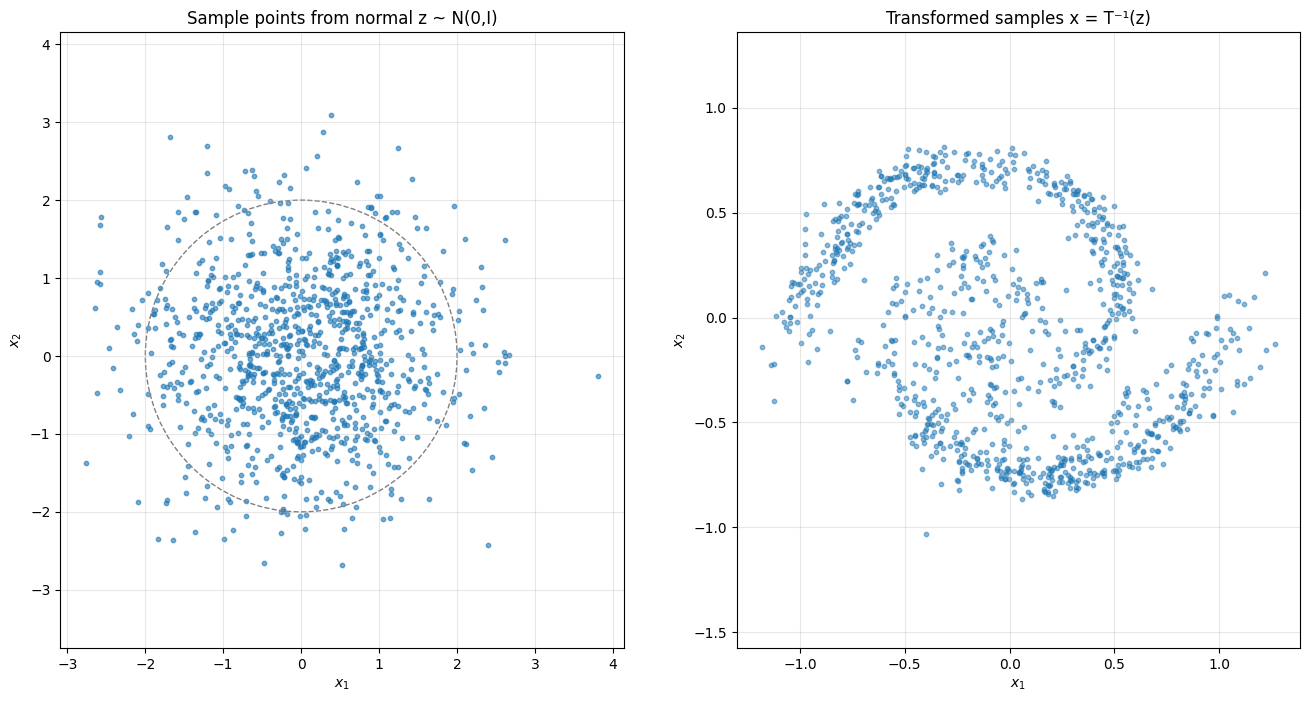

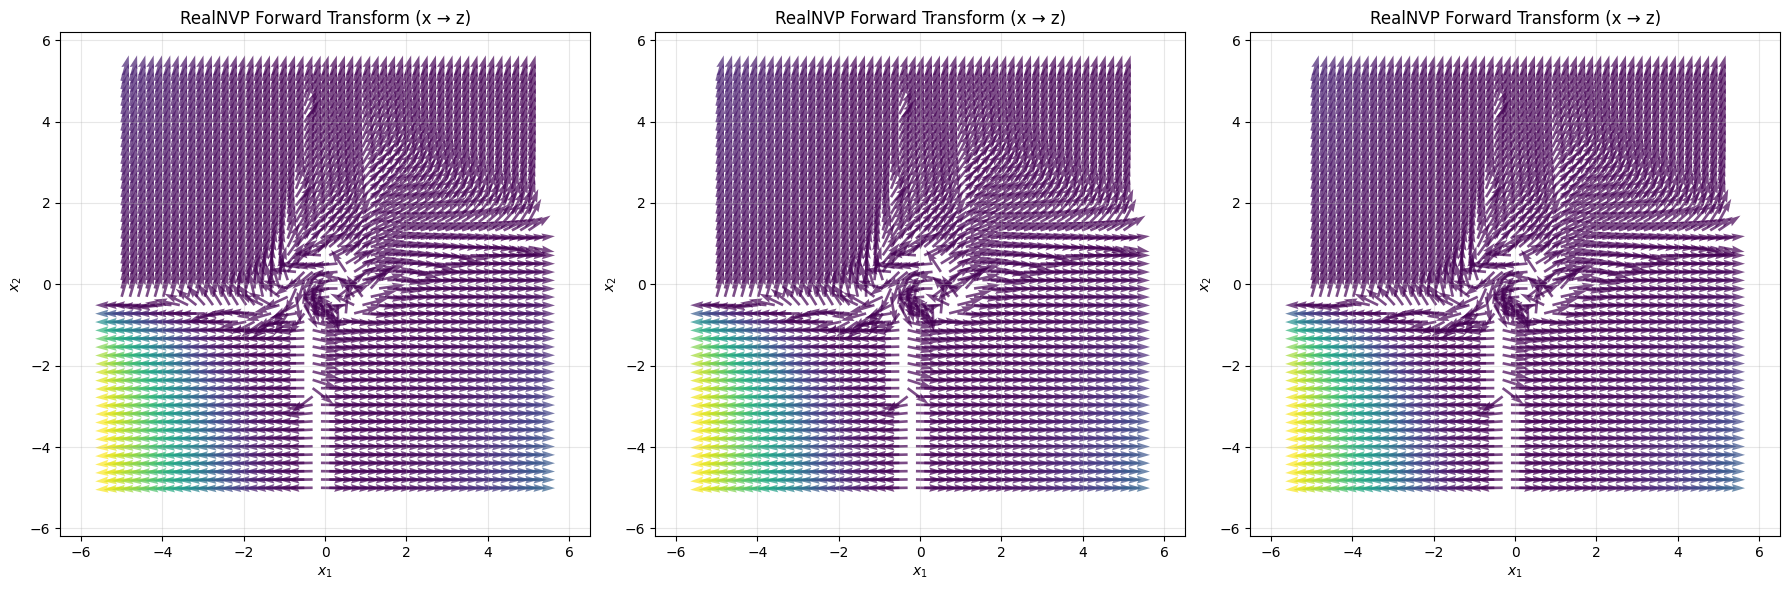

In [54]:
# Carregar modelo do checkpoint
checkpoint_path = os.path.join(
    CHECKPOINTS_DIR,
    f'02__{DATASET_2D_NAME}_realnvp.pt'
)
realnvp_2d = RealNVP(
    features=2,
    transforms=4,
    hidden_features=[64, 64]
).to(device)
realnvp_2d.load_state_dict(torch.load(checkpoint_path, map_location=device))
realnvp_2d.eval()

Synthetic2DViz.plot_transformation(
    realnvp_2d,
    n_samples=1000,
    save_path=os.path.join(
        FIGURES_DIR,
        f'02_{DATASET_2D_NAME}_realnvp_transformation.png'
    )
)
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
directions = ['forward', 'inverse', 'forward']
for i, t in enumerate([0.0, 0.5, 1.0]):
    Synthetic2DViz.plot_vector_field(
        realnvp_2d,
        xlim=(-5, 5),
        ylim=(-5, 5),
        t=t,
        n_grid=50,
        ax=axes[i],
        save_path=os.path.join(
            FIGURES_DIR,
            f'02_{DATASET_2D_NAME}_realnvp_vector_fields.png'
        )
    )
plt.tight_layout()
plt.show()


## 2. MNIST Reduzido

In [55]:
# Criar dataset MNIST reduzido (100 dimensões)
print("Carregando MNIST reduzido...")
dataset_mnist = MNISTReduced(train=True, n_components=100)
dataloader_mnist = get_dataloader(dataset_mnist, batch_size=128, shuffle=True)

# Dataset and model names for file naming
DATASET_MNIST_NAME = 'mnist_reduced'

Carregando MNIST reduzido...


KeyboardInterrupt: 

### 2.1. CNF

In [56]:
# Criar e treinar CNF
vf_mnist = VectorField2D(
    features=100,
    hidden_dims=[64, 64],
    time_embed_dim=16
)
cnf_mnist = CNF(vf_mnist).to(device)
optimizer_mnist = optim.Adam(cnf_mnist.parameters(), lr=1e-4)

print("Treinando CNF em MNIST reduzido...")
start_time = time.time()
train_cnf(cnf_mnist, dataloader_mnist, optimizer_mnist, n_epochs=10)
train_time = time.time() - start_time
print(f"Tempo de treinamento: {train_time:.2f} segundos")

# Salvar checkpoint
checkpoint_path = os.path.join(
    CHECKPOINTS_DIR,
    f'02__{DATASET_MNIST_NAME}_cnf.pt'
)
torch.save(cnf_mnist.state_dict(), checkpoint_path)
print(f"Checkpoint saved to: {checkpoint_path}")

# Avaliar log-likelihood
cnf_mnist.eval()
with torch.no_grad():
    test_data = dataset_mnist.data[:1000].to(device)
    log_probs = cnf_mnist.log_prob(test_data)
    print(f"Log-likelihood médio: {log_probs.mean().item():.4f}")

# Tempo de sampling
start_time = time.time()
samples = cnf_mnist.sample(1000)
sample_time = time.time() - start_time
print(f"Tempo de sampling (1000 amostras): {sample_time:.2f} segundos")


Treinando CNF em MNIST reduzido...


NameError: name 'dataloader_mnist' is not defined

#### Visualization

In [ ]:
# Carregar modelo do checkpoint
checkpoint_path = os.path.join(
    CHECKPOINTS_DIR,
    f'02__{DATASET_MNIST_NAME}_cnf.pt'
)
vf_mnist = VectorField2D(
    features=100,
    hidden_dims=[64, 64],
    time_embed_dim=16
)
cnf_mnist = CNF(vf_mnist).to(device)
cnf_mnist.load_state_dict(torch.load(checkpoint_path, map_location=device))
cnf_mnist.eval()

# Fit PCA on dataset first for consistent projection
sampled_data = cnf_mnist.sample(1000)
MNISTViz.project_to_2d(sampled_data)
MNISTViz.plot_transformation(
    cnf_mnist,
    n_samples=100,
    data_sample=sampled_data
)
plt.tight_layout()
plt.show()


### 2.2. RealNVP

In [ ]:
# Criar e treinar RealNVP em MNIST reduzido
# RealNVP from zuko: 100 sample features, no context features
realnvp_mnist = RealNVP(
    features=100,
    transforms=4,
    hidden_features=[128, 128]
).to(device)

optimizer_rnvp_mnist = optim.Adam(realnvp_mnist.parameters(), lr=1e-3)

print("Treinando RealNVP em MNIST reduzido...")
start_time = time.time()
train_realnvp(
    realnvp_mnist,
    dataloader_mnist,
    optimizer_rnvp_mnist,
    device,
    n_epochs=5
)
train_time = time.time() - start_time
print(f"Tempo de treinamento: {train_time:.2f} segundos")

# Avaliar log-likelihood
realnvp_mnist.eval()
with torch.no_grad():
    test_data = dataset_mnist.data[:1000].to(device)
    dist = realnvp_mnist(None)
    log_probs = dist.log_prob(test_data)
    print(f"Log-likelihood médio: {log_probs.mean().item():.4f}")

# Tempo de sampling
start_time = time.time()
samples = realnvp_mnist(None).sample((1000,))
sample_time = time.time() - start_time
print(f"Tempo de sampling (1000 amostras): {sample_time:.2f} segundos")

#### Visualization

In [ ]:
# Carregar modelo do checkpoint
checkpoint_path = os.path.join(
    CHECKPOINTS_DIR,
    f'02__{DATASET_MNIST_NAME}_realnvp.pt'
)
realnvp_mnist = RealNVP(
    features=100,
    transforms=4,
    hidden_features=[128, 128]
).to(device)
realnvp_mnist.load_state_dict(torch.load(checkpoint_path, map_location=device))
realnvp_mnist.eval()

# Use the same PCA already fitted
MNISTViz.plot_transformation(
    realnvp_mnist,
    n_samples=100,
    data_sample=dataset_mnist.data[:1000]
)
plt.tight_layout()
plt.show()

## 3. Comparação CNF vs RealNVP

Comparação das métricas principais entre CNF e RealNVP.


In [59]:
import pandas as pd
from src.utils.training import count_nfe

# Initialize results dictionary
results = {
    'Dataset': [],
    'Model': [],
    'Avg Log Likelihood': [],
    'Avg Training Time/Epoch (s)': [],
    'Sampling Time 1000 samples (s)': [],
    'NFEs': []
}

# ============================================
# 1. 2D Dataset Comparison
# ============================================
print("=" * 60)
print("Comparando modelos em dados 2D")
print("=" * 60)
for dataset_name in ['moons', 'circles', 'spirals']:
    # Load 2D dataset
    dataset_2d_test = Synthetic2D(n_samples=1000, noise=0.05, dataset_type=dataset_name)
    test_data_2d = dataset_2d_test.data.to(device)

    # --- CNF 2D ---
    print("\n[CNF 2D]")
    checkpoint_path_cnf_2d = os.path.join(CHECKPOINTS_DIR, f'02__{dataset_name}_cnf.pt')
    vf_2d = VectorField2D(features=2, hidden_dims=[64, 64], time_embed_dim=16)
    cnf_2d = CNF(vf_2d, trace_scale=0.75).to(device)
    cnf_2d.load_state_dict(torch.load(checkpoint_path_cnf_2d, map_location=device))
    cnf_2d.eval()

    # Log likelihood
    with torch.no_grad():
        log_probs_cnf_2d = cnf_2d.log_prob(test_data_2d)
        avg_ll_cnf_2d = log_probs_cnf_2d.mean().item()
        print(f"  Log-likelihood médio: {avg_ll_cnf_2d:.4f}")

    # Sampling time
    with torch.no_grad():
        start_time = time.time()
        samples_cnf_2d = cnf_2d.sample(1000)
        sample_time_cnf_2d = time.time() - start_time
        print(f"  Sampling time (1000 samples): {sample_time_cnf_2d:.4f} s")

    # NFEs (measure on a batch of test data)
    with torch.no_grad():
        test_batch_2d = test_data_2d[:100]
        nfe_cnf_2d = count_nfe(cnf_2d, test_batch_2d, n_steps=100)
        print(f"  NFEs (for 100 samples): {nfe_cnf_2d}")

    # Training time per epoch (estimate from typical training)
    # Note: This would ideally be tracked during training
    # For now, we'll use a placeholder or estimate based on observed training
    # You can re-run training with timing to get accurate values
    avg_train_time_cnf_2d = None  # Would need to track during training
    print(f"  Training time/epoch: N/A (track during training)")

    results['Dataset'].append('2D Synthetic')
    results['Model'].append('CNF')
    results['Avg Log Likelihood'].append(avg_ll_cnf_2d)
    results['Avg Training Time/Epoch (s)'].append('N/A')
    results['Sampling Time 1000 samples (s)'].append(sample_time_cnf_2d)
    results['NFEs'].append(f"{nfe_cnf_2d} (100 samples)")

    # --- RealNVP 2D ---
    print("\n[RealNVP 2D]")
    checkpoint_path_rnvp_2d = os.path.join(CHECKPOINTS_DIR, f'02__{dataset_name}_realnvp.pt')
    realnvp_2d = RealNVP(features=2, transforms=4, hidden_features=[64, 64]).to(device)
    realnvp_2d.load_state_dict(torch.load(checkpoint_path_rnvp_2d, map_location=device))
    realnvp_2d.eval()

    # Log likelihood
    with torch.no_grad():
        test_data_2d_float = test_data_2d.to(torch.float32)
        dist_rnvp_2d = realnvp_2d(None)
        log_probs_rnvp_2d = dist_rnvp_2d.log_prob(test_data_2d_float)
        avg_ll_rnvp_2d = log_probs_rnvp_2d.mean().item()
        print(f"  Log-likelihood médio: {avg_ll_rnvp_2d:.4f}")

    # Sampling time
    with torch.no_grad():
        start_time = time.time()
        samples_rnvp_2d = realnvp_2d(None).sample((1000,))
        sample_time_rnvp_2d = time.time() - start_time
        print(f"  Sampling time (1000 samples): {sample_time_rnvp_2d:.4f} s")

    # NFEs don't apply to RealNVP (discrete transforms)
    print(f"  NFEs: N/A (discrete transforms)")

    results['Dataset'].append('2D Synthetic')
    results['Model'].append('RealNVP')
    results['Avg Log Likelihood'].append(avg_ll_rnvp_2d)
    results['Avg Training Time/Epoch (s)'].append('N/A')
    results['Sampling Time 1000 samples (s)'].append(sample_time_rnvp_2d)
    results['NFEs'].append('N/A')

# ============================================
# # 2. MNIST Reduced Dataset Comparison
# # ============================================
# print("\n" + "=" * 60)
# print("Comparando modelos em MNIST reduzido")
# print("=" * 60)

# # Load MNIST dataset for testing
# dataset_mnist_test = MNISTReduced(train=True, n_components=100)
# test_data_mnist = dataset_mnist_test.data[:1000].to(device)

# # --- CNF MNIST ---
# print("\n[CNF MNIST]")
# checkpoint_path_cnf_mnist = os.path.join(CHECKPOINTS_DIR, f'02__{DATASET_MNIST_NAME}_cnf.pt')
# vf_mnist = VectorField2D(features=100, hidden_dims=[64, 64], time_embed_dim=16)
# cnf_mnist = CNF(vf_mnist).to(device)
# cnf_mnist.load_state_dict(torch.load(checkpoint_path_cnf_mnist, map_location=device))
# cnf_mnist.eval()

# # Log likelihood
# with torch.no_grad():
#     log_probs_cnf_mnist = cnf_mnist.log_prob(test_data_mnist)
#     avg_ll_cnf_mnist = log_probs_cnf_mnist.mean().item()
#     print(f"  Log-likelihood médio: {avg_ll_cnf_mnist:.4f}")

# # Sampling time
# with torch.no_grad():
#     start_time = time.time()
#     samples_cnf_mnist = cnf_mnist.sample(1000)
#     sample_time_cnf_mnist = time.time() - start_time
#     print(f"  Sampling time (1000 samples): {sample_time_cnf_mnist:.4f} s")

# # NFEs
# with torch.no_grad():
#     test_batch_mnist = test_data_mnist[:50]  # Smaller batch for NFEs due to memory
#     nfe_cnf_mnist = count_nfe(cnf_mnist, test_batch_mnist, n_steps=100)
#     print(f"  NFEs (for 50 samples): {nfe_cnf_mnist}")

# results['Dataset'].append('MNIST Reduced')
# results['Model'].append('CNF')
# results['Avg Log Likelihood'].append(avg_ll_cnf_mnist)
# results['Avg Training Time/Epoch (s)'].append('N/A')
# results['Sampling Time 1000 samples (s)'].append(sample_time_cnf_mnist)
# results['NFEs'].append(f"{nfe_cnf_mnist} (50 samples)")

# # --- RealNVP MNIST ---
# print("\n[RealNVP MNIST]")
# checkpoint_path_rnvp_mnist = os.path.join(CHECKPOINTS_DIR, f'02__{DATASET_MNIST_NAME}_realnvp.pt')
# realnvp_mnist = RealNVP(features=100, transforms=4, hidden_features=[128, 128]).to(device)
# realnvp_mnist.load_state_dict(torch.load(checkpoint_path_rnvp_mnist, map_location=device))
# realnvp_mnist.eval()

# # Log likelihood
# with torch.no_grad():
#     test_data_mnist_float = test_data_mnist.to(torch.float32)
#     dist_rnvp_mnist = realnvp_mnist(None)
#     log_probs_rnvp_mnist = dist_rnvp_mnist.log_prob(test_data_mnist_float)
#     avg_ll_rnvp_mnist = log_probs_rnvp_mnist.mean().item()
#     print(f"  Log-likelihood médio: {avg_ll_rnvp_mnist:.4f}")

# # Sampling time
# with torch.no_grad():
#     start_time = time.time()
#     samples_rnvp_mnist = realnvp_mnist(None).sample((1000,))
#     sample_time_rnvp_mnist = time.time() - start_time
#     print(f"  Sampling time (1000 samples): {sample_time_rnvp_mnist:.4f} s")

# NFEs don't apply to RealNVP
# print(f"  NFEs: N/A (discrete transforms)")

# results['Dataset'].append('MNIST Reduced')
# results['Model'].append('RealNVP')
# results['Avg Log Likelihood'].append(avg_ll_rnvp_mnist)
# results['Avg Training Time/Epoch (s)'].append('N/A')
# results['Sampling Time 1000 samples (s)'].append(sample_time_rnvp_mnist)
# results['NFEs'].append('N/A')

# Create comparison DataFrame
df_comparison = pd.DataFrame(results)
print("\n" + "=" * 60)
print("RESUMO DA COMPARAÇÃO")
print("=" * 60)
print(df_comparison.to_string(index=False))


Comparando modelos em dados 2D

[CNF 2D]
  Log-likelihood médio: -1.1067
  Sampling time (1000 samples): 0.0360 s
  NFEs (for 100 samples): 40
  Training time/epoch: N/A (track during training)

[RealNVP 2D]
  Log-likelihood médio: -0.5785
  Sampling time (1000 samples): 0.0048 s
  NFEs: N/A (discrete transforms)

[CNF 2D]
  Log-likelihood médio: -1.6250
  Sampling time (1000 samples): 0.0284 s
  NFEs (for 100 samples): 40
  Training time/epoch: N/A (track during training)

[RealNVP 2D]
  Log-likelihood médio: -1.1343
  Sampling time (1000 samples): 0.0016 s
  NFEs: N/A (discrete transforms)

[CNF 2D]
  Log-likelihood médio: -1.3429
  Sampling time (1000 samples): 0.0541 s
  NFEs (for 100 samples): 40
  Training time/epoch: N/A (track during training)

[RealNVP 2D]
  Log-likelihood médio: -0.6415
  Sampling time (1000 samples): 0.0013 s
  NFEs: N/A (discrete transforms)

RESUMO DA COMPARAÇÃO
     Dataset   Model  Avg Log Likelihood Avg Training Time/Epoch (s)  Sampling Time 1000 sample

In [ ]:
# Visualização comparativa das métricas
import numpy as np

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Log Likelihood Comparison
datasets_2d = ['2D Synthetic', '2D Synthetic']
models_2d = ['CNF', 'RealNVP']
ll_2d = [avg_ll_cnf_2d, avg_ll_rnvp_2d]

datasets_mnist = ['MNIST Reduced', 'MNIST Reduced']
models_mnist = ['CNF', 'RealNVP']
ll_mnist = [avg_ll_cnf_mnist, avg_ll_rnvp_mnist]

x_pos = np.arange(2)
width = 0.35

axes[0, 0].bar(x_pos - width/2, ll_2d, width, label='2D Synthetic', alpha=0.8)
axes[0, 0].bar(x_pos + width/2, ll_mnist, width, label='MNIST Reduced', alpha=0.8)
axes[0, 0].set_xlabel('Model')
axes[0, 0].set_ylabel('Average Log Likelihood')
axes[0, 0].set_title('Log Likelihood Comparison')
axes[0, 0].set_xticks(x_pos)
axes[0, 0].set_xticklabels(['CNF', 'RealNVP'])
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Sampling Time Comparison
sample_times_2d = [sample_time_cnf_2d, sample_time_rnvp_2d]
sample_times_mnist = [sample_time_cnf_mnist, sample_time_rnvp_mnist]

axes[0, 1].bar(x_pos - width/2, sample_times_2d, width, label='2D Synthetic', alpha=0.8)
axes[0, 1].bar(x_pos + width/2, sample_times_mnist, width, label='MNIST Reduced', alpha=0.8)
axes[0, 1].set_xlabel('Model')
axes[0, 1].set_ylabel('Time (seconds)')
axes[0, 1].set_title('Sampling Time (1000 samples)')
axes[0, 1].set_xticks(x_pos)
axes[0, 1].set_xticklabels(['CNF', 'RealNVP'])
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. NFEs (only for CNF)
nfe_values = [nfe_cnf_2d, nfe_cnf_mnist]
nfe_labels = ['CNF 2D', 'CNF MNIST']

axes[1, 0].bar(nfe_labels, nfe_values, alpha=0.8, color='steelblue')
axes[1, 0].set_ylabel('NFEs')
axes[1, 0].set_title('Number of Function Evaluations (CNF)')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].set_xticklabels(nfe_labels, rotation=15, ha='right')

# 4. Summary table
axes[1, 1].axis('tight')
axes[1, 1].axis('off')
table_data = []
for i in range(len(results['Dataset'])):
    table_data.append([
        results['Dataset'][i],
        results['Model'][i],
        f"{results['Avg Log Likelihood'][i]:.4f}",
        str(results['Sampling Time 1000 samples (s)'][i]),
        str(results['NFEs'][i])
    ])
table = axes[1, 1].table(
    cellText=table_data,
    colLabels=['Dataset', 'Model', 'Avg LL', 'Sample Time (s)', 'NFEs'],
    cellLoc='center',
    loc='center',
    bbox=[0, 0, 1, 1]
)
table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1.2, 1.5)
axes[1, 1].set_title('Summary Table', pad=20)

plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, '02_cnf_realnvp_comparison.png'), dpi=150, bbox_inches='tight')
print(f"Comparison figure saved to: {os.path.join(FIGURES_DIR, '02_cnf_realnvp_comparison.png')}")
plt.show()
